# Case 3. Drug Reviews

* Author: Martin Roznovjak
* Last edited: 2019-03-21
* Organization: [Metropolia University of Applied Sciences](https://www.metropolia.fi/)

## What is this?

This is an assignment for *Cognitive Systems for Health Technology Applications* course.

The goal was to design a model for **drug rating prediction based on its review** in the [UCI Drug Review dataset](https://archive.ics.uci.edu/ml/datasets/Drug+Review+Dataset+%28Drugs.com%29).

### Brief overview of the results
The model was trained to predict original labels from reviews,
both using a discrete classifier and a single variable regression.
Based on a validation set,
it reaches about 0.85 mean average error,
0.54 Cohen's kappa score, 0.62 accuracy.
The full results can be found at the bottom.


### You can find here
 * brief overview of the dataset
 * text (pre)processing
 * decision supporting analysis
 * my final model's architecture, training and evaluation
 * comments along the way

I decided not to include exploratory analysis of the dataset,
as there already are many good resources available, for instance:
 - [Exploratory Data Analysis w/ Python](https://www.kaggle.com/lkuffo/exploratory-data-analysis-w-python)
 - [Kaggle Starter](https://www.kaggle.com/kerneler/starter-uci-ml-drug-review-dataset-b99672ef-0)
 - [Data analysis and first classification experiments](https://github.com/sakluk/cognitive-systems-for-health-technology/blob/master/Week%206.%20Case%203%20-%20First%20classification%20experiments.ipynb)

Other resources:
 - [this dataset on Kaggle](https://www.kaggle.com/jessicali9530/kuc-hackathon-winter-2018)
 - [original paper](https://dl.acm.org/citation.cfm?id=3194677)
 - [similar kernel](https://www.kaggle.com/stasian/predicting-review-scores-using-neural-networks)

## Let's begin!

In [1]:
VOCABULARY_SIZE = 4095
VALIDATION_SPLIT = 0.25
SPACY_MODEL = 'en_core_web_lg'

In [2]:
# basic imports
import os

import IPython

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras import layers
from keras.regularizers import l1, l2

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [4]:
# an NLP library
# get a model with pretrained embeddings and load it

# if GPU is on, Internet connection is needed in Kaggle kernels!
!python -m spacy download $SPACY_MODEL

import spacy
nlp = spacy.load(SPACY_MODEL)


    Creating a shortcut link for 'en' didn't work (maybe you don't have
    admin permissions?), but you can still load the model via its full
    package name: nlp = spacy.load('{name}')
    Download successful but linking failed



In [27]:
# convenience settings

### plotting ###
# prettier and larger basic graphs
sns.set(rc={
    'figure.figsize':(18,8),
    'axes.titlesize':14,
})

### pandas ###
# make the tables more compact vertically, too
pd.options.display.max_rows = 20

## Loading the data

I have been training models mostly in Kaggle and mirrored my local directory structure accordingly.

In [28]:
print(os.listdir("../input"))

['drugsComTrain_raw.csv', 'drugsComTest_raw.csv']


In [29]:
# load and preview the training set
reviews_df = pd.read_csv('../input/drugsComTrain_raw.csv')
reviews_df

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37
5,155963,Cialis,Benign Prostatic Hyperplasia,"""2nd day on 5mg started to work with rock hard...",2,28-Nov-15,43
6,165907,Levonorgestrel,Emergency Contraception,"""He pulled out, but he cummed a bit in me. I t...",1,7-Mar-17,5
7,102654,Aripiprazole,Bipolar Disorde,"""Abilify changed my life. There is hope. I was...",10,14-Mar-15,32
8,74811,Keppra,Epilepsy,""" I Ve had nothing but problems with the Kepp...",1,9-Aug-16,11
9,48928,Ethinyl estradiol / levonorgestrel,Birth Control,"""I had been on the pill for many years. When m...",8,8-Dec-16,1


In [30]:
# once more for the test set
reviews_test_df = pd.read_csv('../input/drugsComTest_raw.csv')
reviews_test_df

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,28-Feb-12,22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,17-May-09,17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,29-Sep-17,3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,5-Mar-17,35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,22-Oct-15,4
5,208087,Zyclara,Keratosis,"""4 days in on first 2 weeks. Using on arms an...",4,3-Jul-14,13
6,215892,Copper,Birth Control,"""I&#039;ve had the copper coil for about 3 mon...",6,6-Jun-16,1
7,169852,Amitriptyline,Migraine Prevention,"""This has been great for me. I&#039;ve been on...",9,21-Apr-09,32
8,23295,Methadone,Opiate Withdrawal,"""Ive been on Methadone for over ten years and ...",7,18-Oct-16,21
9,71428,Levora,Birth Control,"""I was on this pill for almost two years. It d...",2,16-Apr-11,3


The reviews are quite unhealthy - they contain bad stuff for tokenizers such as `&#039;` *(HTML code for apostrophe)*,
let's take some remedy before going further...

In [31]:
# sanitizing review text

from html import unescape

def clean_review(text):
    """Replace HTML escaped characters, byte order mark
    and strip outer quotes and spaces"""
    return unescape(text.strip(' "\'')).replace('\ufeff1', '')

reviews_df.review = reviews_df.review.apply(clean_review)
reviews_test_df.review = reviews_test_df.review.apply(clean_review)

## A bit of insight

### *What do they talk about?*

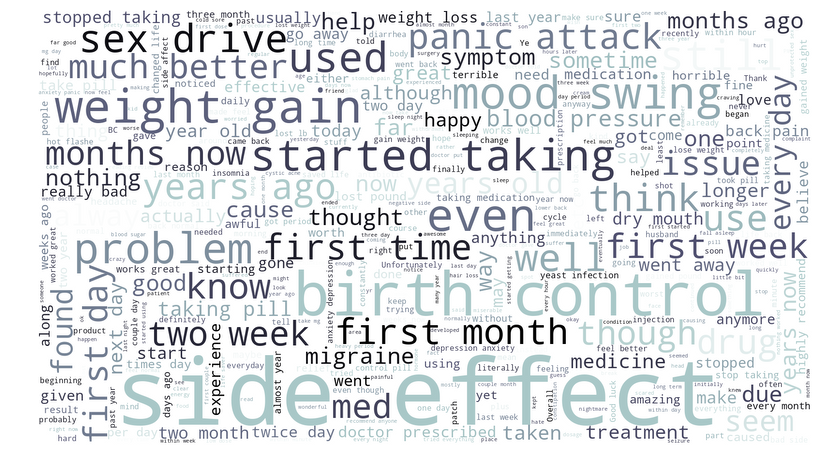

In [33]:
from wordcloud import WordCloud

wordcloud = WordCloud(
    width=1600,
    height=900,
    random_state=2019,
    background_color='white',
    max_words=400,
    colormap='bone'
)

wordcloud.generate('\n'.join(reviews_df.review))
plt.imshow(wordcloud, interpolation='lanczos')
plt.axis('off')
plt.show()

In [180]:
markdown = '### A peek at some reviews\n'
for idx, row in reviews_df.sample(10).iterrows():
    markdown += f'\n\nReview {row.uniqueID}\n\n> '
    markdown += '\n> '.join(row.review.splitlines())
    
IPython.display.Markdown(markdown)

#### A peek at some reviews


Review 10827

> I went on this bc my period was so irregular and it was getting out of control. When I first went on this bc I threw up for the first 3 days and then after that I was fine. 2 weeks after I began my mood swings increased a lot, it was really unpredictable what my mood will be like. I've also been throwing up ever since I went on this
> 
> bc. My appetite has decreased, I've gained weight, I always feel bloated, my mood is terrible and everything makes my stomach feel sick. I hate throwing up so this pill has been the worse to me. Definitely a waste of my time.

Review 75618

> First I want to advise others that Deplin is an adjunct to your antidepressant, not an antidepressant. I am on day 4, and already feel more clarity, better mood, and more energy.
> 
> 
> 
> I have Narcoplesy, untreated due to allergic to meds for this condition. So, greater energy and more awake so great.
> 
> 
> 
>  In addition, I have been battling severe Irritable Bowel Syndrome, Gastritis and severe upper gastric pain for 10 months.  Most days I have been unable to eat other than breakfast. The evening of my first day of Deplin, greatly reduced my irritable bowel issues, and since then little to no pain. I had a ham and cheese sub yesterday. It is like a miracle.
> 
> 
> 
> Good luck to those prescribed this medication.

Review 118086

> I had a brief episode of a-fib following severe pneumonia, so the docs put me on Eliquis and have insisted I stick with it despite the fact my a-fib resolved on its own two weeks after multiple failed cardioversion attempts and a course of amiodarone. 
> 
> Now I find myself having dark, very bloody bowel movements accompanied by severe abdominal cramping. Yuck. I have IBS, but this is different. 
> 
> Time to insist my docs take me off of it?

Review 56640

> I was taking an SSRI antidepressant and other depression medicines but they didn't work. I started taking this and felt way better than I did before. I've been taking it for a while and got used to the sedating side effects and it's helped me from the first time I took it.

Review 3312

> As a third line of attack against my persistent uti this stuff worked where Amoxyl had failed. No side effects.

Review 138444

> I am just over halfway through my 3 month Adipex regimen and am feeling great. For anyone struggling with weight loss, I highly recommend asking your doctor about Adipex. My physician was very quick to prescribe it as soon as I asked about it, as he could tell I did my research. I am 5'5, 25 y/o, and started at 193.5lbs.
> 
> The biggest pro about this medication is that it almost completely rid me of my uncontrollable cravings (I don't even think about chocolate anymore). With that out of the way, I am now able to more easily make healthy changes to my lifestyle. I have started eating more vegan-like and making being active part of my daily life. So far I am down 19.7 pounds. I feel like myself again!

Review 31346

> I got the generic 3 day pack with external cream (can't afford the doc). I came looking to find out how long it has to be in bc I was only going to get 4 or 5 hrs sleep, but never found an answer. I saw these reviews, but again, no choice. 
> 
> At 1st it wasn't bad, but after 6 mins, it was severe itching & I wondered if I could safely scratch inside with the applicator. I didn't do it, but i was SORELY TEMPTED.  There wasn't too much pain, but maybe it's bc I caught mine early. 
> 
> The only reason I fell asleep is bc I'd been awake for so long. Otherwise, there is NO WAY I could have. I'm hoping tomorrow is better. I will try to come back and post again since I have no real choice about taking it.

Review 170134

> No dude it doesn't work. I've been on it for few months. No it doesn't work for anxiety. It helps the shaking part. That's it. Doesn't work for depression either. When I was on it I hurt myself and was thinking about suicide. It didn't stop my racing thought. My OCD is the same. Man just no. I gained 40 pounds in 2 months just with 250mg. It's the worst medication of its category. I was on Zyprexa before but besides the horrible weight gain at least I was doing much better. I hate this medication. Do not take it people. It makes you fat doesn't help at all. No man just NOOO. I'm going back to Paxil 30mg and Zyprexa 7.5 mg which work so much better. Bye SEROQUEL.

Review 39093

> Suffering through the side effects in the first week (headaches, nausea, dizziness) but have lost 4 pounds already.  Hoping the side effects will taper off as this medication definitely controls my hunger and cravings.

Review 20283

> Mama said "If it's too good to be true, it probably is".  Except for Cambia.  This is good stuff.  I get headaches so often I don't often notice unless it's a bad one.  Relief comes within 10 to 15 minutes. Maybe even less on an empty stomach.  Pain, throbbing, sensitivity, all of it.  Best part- I can take it at work (elementary special needs teacher) with no impairment, drowsiness, or pesky side effects whatsoever. That's a BIG deal when working with kids.  I keep two packets in my wallet at all times. 
> 
> PS: The taste, mint and black jellybeans, was hard for me to swallow at first.  But it's no worse than NyQuil or Robitussin or any of the other horrid things we take to feel better. So what?

## Text preprocessing

I was trying out different styles of preprocessing and as expected embeddings turned out to be the most helpful
and using pretrained embeddings sped up the trainings.

Stop words, punctuation and, surprisingly, even numbers were benefiacial when
being included in the vocabulary for this model's performance (both for training and validation).

On the other hand, dropping out-of-vocabulary words or replacing them with a reserved index
brought positive results for some architectures, negative for others,
in case of the model in this notebook it appears that generalization is slightly better
with out-of-vocabulary words being kept and replaced with a common index (0).

In [7]:
IPython.display.Markdown(
    f"I will use spaCy's `{SPACY_MODEL}` model for tokenizing reviews and the embeddings, "
    f"the model has {len(nlp.vocab)} lexemes in its vocabulary "
    f"and {len(nlp.vocab.vectors)} have embeddings of length {nlp.vocab.vectors_length}."
)

I will use spaCy's `en_core_web_lg` model for tokenizing reviews and the embeddings, the model has 1344233 lexemes in its vocabulary and 684831 have embeddings of length 300.

In [35]:
# sequencing review text

def text2tokens(text):
    """text -> tokenize -> lemmatize/normalize"""
    
    tokens = nlp(
        # also split on "/"
        text.replace('/', ' / '),
        
        # we only need tokenizer and lemmas, so disable the rest
        disable=['tagger', 'parser', 'ner']
    )
    
    lexemes = []
    for token in tokens:
        
        # sometimes whitespace gets recognized as a token...
        if token.text.isspace():
            continue
            
        # prefer more general representations
        # but only if they have an embedding
        if nlp.vocab[token.lemma_.lower()].has_vector:
            lexeme = token.lemma_.lower()
        elif nlp.vocab[token.norm_.lower()].has_vector:
            lexeme = token.norm_.lower()
        else:
            lexeme = token.lower_
        
        lexemes.append(lexeme)
        
    return lexemes

reviews_word_seq = [text2tokens(review) for review in reviews_df.review]
reviews_test_word_seq = [text2tokens(review) for review in reviews_test_df.review]

In [119]:
# count occurences of each word/token

word_count = {}
for lemmas in reviews_word_seq:
    for lemma in lemmas:
        word_count[lemma] = word_count.get(lemma, 0) + 1
word_count = dict(sorted(word_count.items(), key=lambda pair: pair[1], reverse=True))

In [118]:
# display a table of the most frequent words

# keep it within our vocabulary
show_words = min(1000, VOCABULARY_SIZE)
columns = 5

markdown_rows = []
markdown_rows.append(f'#### Top {show_words} most frequent tokens\n')
markdown_rows.append('| Token | Count '*columns + '|')
markdown_rows.append('| ---: | :---- '*columns + '|')

row = ''
for index, (word, count) in enumerate(word_count.items()):
    if index >= show_words: break
    if index%columns == 0 and row:
        markdown_rows.append(row + '|')
        row = ''
    row += f'| {word} | {count} '
if row:
    markdown_rows.append(row + '|')
    
IPython.display.Markdown('\n'.join(markdown_rows))

#### Top 1000 most frequent tokens

| Token | Count | Token | Count | Token | Count | Token | Count | Token | Count |
| ---: | :---- | ---: | :---- | ---: | :---- | ---: | :---- | ---: | :---- |
| . | 862552 | i | 856875 | be | 587319 | have | 455315 | and | 431685 |
| , | 426565 | the | 407117 | a | 366904 | to | 323632 | it | 317498 |
| my | 292527 | for | 201810 | not | 188062 | of | 171731 | this | 144229 |
| on | 136947 | take | 132159 | in | 126630 | but | 123481 | me | 115680 |
| that | 113610 | do | 112851 | with | 104883 | day | 97560 | ! | 92287 |
| get | 87593 | so | 82912 | feel | 71091 | month | 69045 | go | 66720 |
| year | 65793 | at | 64404 | after | 63125 | much | 62738 | no | 60163 |
| work | 59198 | week | 58003 | effect | 56208 | about | 55990 | now | 55275 |
| side | 53950 | start | 53900 | can | 53163 | time | 51161 | all | 49929 |
| pain | 48406 | 2 | 48106 | - | 46240 | ) | 45716 | mg | 45618 |
| first | 45032 | ( | 44472 | you | 43459 | only | 42753 | like | 42747 |
| up | 42449 | pill | 41760 | would | 41539 | period | 40085 | just | 40081 |
| very | 39785 | use | 39626 | out | 38713 | 3 | 38354 | good | 38332 |
| or | 38329 | from | 38253 | when | 36701 | will | 35574 | because | 35414 |
| if | 34550 | try | 34155 | help | 33785 | make | 33654 | one | 31844 |
| medication | 31753 | back | 31729 | well | 31325 | doctor | 31189 | / | 29243 |
| little | 29114 | also | 28275 | weight | 27673 | before | 27393 | then | 27333 |
| which | 26112 | give | 25690 | medicine | 25542 | life | 25473 | since | 25438 |
| experience | 25195 | other | 24918 | bad | 24569 | stop | 24541 | still | 24509 |
| off | 24224 | anxiety | 24169 | any | 23953 | sleep | 23791 | really | 23775 |
| some | 23459 | over | 23037 | think | 22956 | control | 22714 | never | 22445 |
| hour | 22250 | last | 22146 | than | 22068 | 4 | 21931 | they | 21791 |
| two | 21548 | say | 21119 | even | 21062 | " | 20931 | night | 20744 |
| gain | 20435 | 5 | 20321 | every | 20309 | 10 | 19844 | great | 19563 |
| few | 19068 | drug | 18932 | cramp | 18863 | wrong | 18298 | dose | 18261 |
| long | 17976 | again | 17948 | ago | 17678 | thing | 17596 | by | 17553 |
| lose | 17243 | acne | 16976 | 1 | 16821 | birth | 16796 | prescribe | 16712 |
| depression | 16255 | 6 | 16092 | know | 15761 | what | 15675 | see | 15596 |
| come | 15507 | bleed | 15360 | eat | 15098 | almost | 15061 | problem | 15029 |
| want | 14895 | down | 14839 | there | 14789 | find | 14784 | change | 14781 |
| headache | 14767 | severe | 14610 | put | 14583 | recommend | 14203 | lot | 14116 |
| he | 14068 | mood | 14033 | need | 13749 | your | 13745 | ... | 13373 |
| far | 13331 | notice | 13020 | ever | 12855 | skin | 12846 | & | 12798 |
| nothing | 12671 | tell | 12591 | away | 12416 | nausea | 12410 | symptom | 12303 |
| sex | 12136 | too | 11990 | normal | 11616 | keep | 11253 | old | 11228 |
| 20 | 11217 | love | 11095 | without | 11046 | late | 11025 | seem | 11024 |
| morning | 11010 | while | 10978 | body | 10775 | however | 10672 | spot | 10527 |
| them | 10524 | its | 10406 | until | 10331 | low | 10312 | clear | 10249 |
| within | 10169 | hope | 10053 | how | 10003 | always | 9934 | switch | 9922 |
| horrible | 9902 | once | 9890 | many | 9884 | next | 9766 | suffer | 9729 |
| may | 9691 | happy | 9550 | around | 9544 | through | 9521 | she | 9427 |
| pound | 9396 | due | 9375 | blood | 9364 | able | 9337 | right | 9332 |
| doe | 9332 | stomach | 9303 | finally | 9234 | migraine | 9193 | increase | 9168 |
| begin | 9114 | three | 9069 | 8 | 9057 | 7 | 9024 | could | 8963 |
| myself | 8920 | light | 8845 | high | 8835 | different | 8622 | issue | 8608 |
| sure | 8510 | way | 8483 | same | 8443 | during | 8442 | who | 8438 |
| though | 8368 | 30 | 8352 | read | 8351 | drive | 8327 | cause | 8307 |
| we | 8303 | drink | 8264 | people | 8256 | daily | 8195 | wake | 8186 |
| .. | 8144 | swing | 8108 | anything | 8087 | become | 8008 | attack | 8001 |
| completely | 7936 | review | 7898 | another | 7840 | face | 7714 | something | 7691 |
| couple | 7667 | into | 7512 | everything | 7455 | result | 7436 | dry | 7404 |
| half | 7391 | lb | 7324 | bite | 7288 | panic | 7272 | end | 7269 |
| minute | 7254 | : | 7233 | new | 7218 | heavy | 7211 | break | 7101 |
| infection | 7068 | ? | 7020 | 15 | 7012 | worth | 6989 | stay | 6967 |
| tire | 6950 | shoot | 6928 | terrible | 6815 | relief | 6776 | loss | 6748 |
| decide | 6744 | leave | 6711 | painful | 6632 | pretty | 6625 | look | 6561 |
| appetite | 6547 | extremely | 6520 | effective | 6510 | past | 6507 | actually | 6449 |
| today | 6400 | definitely | 6399 | pregnant | 6335 | water | 6322 | where | 6285 |
| continue | 6135 | bed | 6123 | hard | 5996 | full | 5819 | 100 | 5780 |
| burn | 5780 | treatment | 5777 | meds | 5764 | twice | 5736 | sometimes | 5701 |
| diagnose | 5640 | several | 5636 | ; | 5628 | depress | 5607 | product | 5583 |
| 50 | 5576 | should | 5555 | everyone | 5474 | % | 5464 | worry | 5447 |
| happen | 5416 | fine | 5402 | anyone | 5395 | live | 5375 | enough | 5366 |
| insurance | 5340 | pressure | 5336 | mouth | 5325 | sick | 5305 | dosage | 5266 |
| 12 | 5222 | food | 5214 | fall | 5198 | point | 5197 | big | 5181 |
| energy | 5162 | soon | 5073 | level | 5052 | small | 4966 | taste | 4958 |
| insert | 4913 | mild | 4907 | both | 4905 | already | 4878 | negative | 4861 |
| cry | 4860 | wait | 4856 | patch | 4853 | hurt | 4849 | free | 4846 |
| head | 4827 | deal | 4777 | difference | 4775 | else | 4770 | 9 | 4766 |
| leg | 4735 | insertion | 4731 | heart | 4716 | 25 | 4575 | plan | 4566 |
| amaze | 4565 | injection | 4556 | overall | 4554 | hair | 4529 | remove | 4527 |
| exercise | 4519 | maybe | 4483 | affect | 4468 | insomnia | 4465 | dr | 4449 |
| breast | 4441 | recently | 4428 | her | 4410 | absolutely | 4407 | diarrhea | 4406 |
| smoke | 4394 | itch | 4387 | extreme | 4375 | awful | 4374 | sweat | 4370 |
| med | 4362 | usually | 4347 | anymore | 4346 | easy | 4320 | walk | 4313 |
| short | 4273 | 40 | 4268 | eye | 4240 | $ | 4225 | quit | 4216 |
| reason | 4216 | test | 4207 | disorder | 4205 | muscle | 4194 | here | 4165 |
| etc | 4144 | per | 4137 | whole | 4127 | immediately | 4112 | pack | 4105 |
| ask | 4099 | cold | 4096 | call | 4093 | surgery | 4068 | miracle | 4067 |
| each | 4056 | as | 4045 | had | 4031 | diet | 3983 | ' | 3981 |
| pregnancy | 3952 | major | 3943 | wonder | 3931 | yet | 3918 | constant | 3911 |
| remember | 3897 | although | 3894 | hand | 3886 | crazy | 3885 | job | 3876 |
| 24 | 3868 | stress | 3858 | person | 3851 | believe | 3844 | fatigue | 3823 |
| thought | 3820 | thank | 3817 | along | 3815 | sore | 3796 | chronic | 3795 |
| please | 3784 | reduce | 3781 | vomit | 3781 | mirena | 3759 | bloat | 3748 |
| positive | 3731 | nauseous | 3725 | why | 3712 | improve | 3710 | let | 3708 |
| part | 3700 | cough | 3684 | everyday | 3678 | swell | 3673 | yr | 3666 |
| early | 3660 | prescription | 3659 | such | 3654 | cycle | 3636 | lexapro | 3632 |
| slight | 3625 | fast | 3625 | zoloft | 3624 | tablet | 3613 | scare | 3599 |
| run | 3596 | wish | 3546 | decrease | 3525 | regular | 3525 | follow | 3518 |
| wear | 3466 | asleep | 3461 | pay | 3450 | highly | 3432 | nexplanon | 3387 |
| under | 3378 | cream | 3368 | stuff | 3367 | add | 3344 | arm | 3335 |
| talk | 3334 | four | 3316 | doc | 3307 | constipation | 3304 | constantly | 3272 |
| stick | 3268 | mind | 3264 | child | 3245 | move | 3223 | drop | 3210 |
| home | 3208 | was | 3196 | started | 3186 | turn | 3185 | school | 3184 |
| cover | 3183 | er | 3179 | .... | 3171 | calm | 3162 | his | 3152 |
| foot | 3151 | suggest | 3147 | bc | 3142 | place | 3142 | probably | 3139 |
| either | 3136 | quite | 3128 | save | 3116 | withdrawal | 3115 | okay | 3111 |
| dizziness | 3080 | took | 3074 | hate | 3059 | generic | 3052 | implant | 3049 |
| chest | 3043 | function | 3040 | dizzy | 3040 | reaction | 3029 | healthy | 3003 |
| emotional | 3001 | improvement | 3001 | hormone | 2999 | hot | 2999 | hospital | 2994 |
| him | 2988 | care | 2977 | husband | 2962 | type | 2961 | antibiotic | 2960 |
| iud | 2942 | develope | 2934 | treat | 2910 | ache | 2903 | 18 | 2899 |
| plus | 2899 | literally | 2892 | quickly | 2876 | huge | 2870 | super | 2869 |
| age | 2843 | yes | 2836 | except | 2829 | xanax | 2824 | knee | 2814 |
| dream | 2808 | anxious | 2804 | finish | 2795 | sugar | 2789 | amount | 2768 |
| focus | 2759 | family | 2739 | 16 | 2738 | realize | 2737 | miss | 2736 |
| post | 2728 | pass | 2712 | cost | 2691 | rest | 2689 | between | 2679 |
| kind | 2668 | weigh | 2648 | friend | 2637 | trouble | 2628 | cymbalta | 2624 |
| moody | 2623 | implanon | 2610 | glad | 2608 | brain | 2604 | entire | 2591 |
| form | 2584 | strong | 2562 | 14 | 2555 | wonderful | 2554 | 60 | 2554 |
| kid | 2550 | neck | 2546 | cut | 2541 | boyfriend | 2529 | luck | 2528 |
| especially | 2512 | baby | 2509 | rate | 2499 | currently | 2493 | self | 2491 |
| return | 2488 | b | 2484 | red | 2478 | non | 2476 | expensive | 2474 |
| struggle | 2464 | son | 2453 | bipolar | 2441 | hear | 2438 | throw | 2437 |
| joint | 2434 | course | 2431 | 2nd | 2426 | prior | 2425 | been | 2422 |
| prozac | 2421 | instead | 2412 | honestly | 2411 | totally | 2410 | depo | 2405 |
| often | 2401 | fact | 2400 | size | 2392 | woman | 2390 | suppose | 2388 |
| 2015 | 2378 | hungry | 2363 | mean | 2359 | brand | 2359 | term | 2358 |
| barely | 2356 | expect | 2352 | forget | 2351 | straight | 2346 | prevent | 2344 |
| 150 | 2334 | nearly | 2328 | bowel | 2325 | 3rd | 2317 | guess | 2313 |
| area | 2307 | effexor | 2295 | six | 2293 | bathroom | 2265 | 11 | 2264 |
| real | 2264 | include | 2261 | check | 2260 | dr. | 2255 | sit | 2253 |
| rather | 2249 | apply | 2248 | numb | 2244 | buy | 2244 | wellbutrin | 2242 |
| active | 2241 | yeast | 2236 | subside | 2233 | someone | 2220 | pimple | 2218 |
| weird | 2217 | must | 2212 | consider | 2207 | breakout | 2200 | 1st | 2195 |
| anti | 2189 | case | 2188 | yesterday | 2186 | god | 2180 | antidepressant | 2176 |
| slowly | 2156 | hopefully | 2153 | their | 2148 | intense | 2133 | works | 2114 |
| sleepy | 2111 | normally | 2096 | condition | 2092 | relieve | 2079 | paxil | 2067 |
| unfortunately | 2057 | five | 2055 | craving | 2054 | seizure | 2037 | close | 2016 |
| upset | 2015 | skyla | 2002 | procedure | 2000 | rash | 1996 | min | 1990 |
| minor | 1988 | rid | 1988 | health | 1987 | none | 1986 | nerve | 1986 |
| nose | 1971 | kick | 1967 | hr | 1966 | possible | 1965 | nightmare | 1950 |
| awake | 1949 | 200 | 1949 | write | 1943 | total | 1943 | slightly | 1940 |
| breathe | 1934 | episode | 1933 | eventually | 1928 | nervous | 1927 | serious | 1924 |
| own | 1911 | flash | 1908 | 17 | 1894 | celexa | 1891 | adhd | 1882 |
| option | 1876 | fibromyalgia | 1875 | uncomfortable | 1874 | allow | 1871 | throat | 1868 |
| mention | 1864 | system | 1861 | allergy | 1859 | slow | 1855 | hit | 1850 |
| complete | 1847 | suicidal | 1847 | concern | 1841 | yaz | 1838 | meal | 1836 |
| sinus | 1826 | research | 1820 | 300 | 1817 | sensitive | 1816 | difficult | 1810 |
| 75 | 1805 | bottle | 1791 | 2016 | 1790 | irregular | 1785 | single | 1780 |
| adjust | 1772 | dermatologist | 1769 | zero | 1767 | show | 1766 | p.m. | 1765 |
| clean | 1760 | tri | 1755 | truly | 1747 | spend | 1742 | occasional | 1737 |
| benefit | 1731 | send | 1730 | minimal | 1726 | easily | 1725 | 90 | 1720 |
| irritable | 1719 | chantix | 1719 | seroquel | 1714 | patient | 1713 | bring | 1712 |
| vision | 1708 | disease | 1707 | usual | 1706 | relax | 1705 | handle | 1701 |
| social | 1698 | cure | 1697 | unbearable | 1697 | sprintec | 1692 | allergic | 1692 |
| enjoy | 1691 | stand | 1684 | combination | 1681 | daughter | 1679 | libido | 1674 |
| loestrin | 1664 | throughout | 1661 | arthritis | 1654 | nuvaring | 1645 | our | 1645 |
| grow | 1642 | lack | 1640 | hell | 1634 | syndrome | 1631 | 80 | 1627 |
| lie | 1626 | ambien | 1624 | disappear | 1620 | perfect | 1620 | 13 | 1620 |
| mostly | 1614 | story | 1610 | unable | 1609 | large | 1606 | state | 1596 |
| discomfort | 1594 | miserable | 1594 | angry | 1593 | complaint | 1593 | female | 1590 |
| condom | 1585 | ear | 1583 | feeling | 1581 | bone | 1581 | adderall | 1579 |
| moderate | 1570 | avoid | 1566 | itchy | 1561 | movement | 1560 | contrave | 1556 |
| quick | 1554 | compare | 1550 | 500 | 1549 | a.m. | 1544 | went | 1543 |
| xr | 1542 | pharmacy | 1541 | flu | 1538 | figure | 1536 | awesome | 1533 |
| flare | 1531 | mine | 1529 | klonopin | 1529 | x | 1527 | -- | 1527 |
| breath | 1527 | sad | 1526 | house | 1523 | lyrica | 1522 | spasm | 1522 |
| cyst | 1518 | process | 1517 | manage | 1514 | cancer | 1514 | afraid | 1513 |
| ring | 1511 | shot | 1511 | annoy | 1510 | shoulder | 1506 | cystic | 1504 |
| ready | 1501 | anyway | 1499 | march | 1498 | lip | 1496 | pristiq | 1491 |
| memory | 1488 | alcohol | 1485 | fear | 1483 | shake | 1482 | top | 1480 |
| breakthrough | 1478 | lo | 1474 | prep | 1469 | therapy | 1458 | appointment | 1455 |
| inside | 1454 | discharge | 1453 | suboxone | 1449 | sample | 1449 | receive | 1448 |
| price | 1433 | initially | 1431 | middle | 1423 | kill | 1420 | sexual | 1415 |
| hardly | 1412 | method | 1407 | 21 | 1404 | ten | 1401 | race | 1401 |
| name | 1399 | idea | 1398 | 45 | 1396 | update | 1391 | june | 1391 |
| money | 1390 | july | 1390 | choice | 1390 | uti | 1387 | fe | 1385 |
| second | 1384 | fever | 1383 | ibuprofen | 1381 | tingle | 1374 | mess | 1373 |
| matt | 1372 | relate | 1368 | nice | 1366 | extra | 1363 | ortho | 1358 |
| nurse | 1355 | basically | 1352 | mix | 1352 | understand | 1351 | psychiatrist | 1350 |
| mental | 1348 | comment | 1345 | helpful | 1345 | multiple | 1336 | hormonal | 1334 |
| emotion | 1333 | bedtime | 1332 | bladder | 1332 | exactly | 1330 | quality | 1330 |
| discontinue | 1327 | regulate | 1327 | freak | 1322 | hold | 1320 | loose | 1317 |
| noticeable | 1314 | tried | 1311 | best | 1310 | gel | 1302 | pm | 1300 |
| wife | 1300 | 2014 | 1298 | physical | 1296 | january | 1292 | watch | 1292 |
| young | 1291 | tramadol | 1289 | wash | 1287 | speak | 1287 | open | 1287 |
| abdominal | 1286 | us | 1285 | heal | 1283 | general | 1283 | smell | 1282 |
| accutane | 1280 | otherwise | 1274 | 19 | 1273 | relationship | 1269 | site | 1265 |
| vyvanse | 1264 | visit | 1263 | abilify | 1262 | significant | 1262 | lamictal | 1261 |
| august | 1260 | previously | 1256 | frequent | 1255 | flow | 1255 | college | 1255 |
| saver | 1250 | kidney | 1249 | room | 1249 | success | 1248 | disc | 1247 |
| chance | 1246 | drowsy | 1239 | situation | 1233 | near | 1227 | fail | 1226 |
| tomorrow | 1225 | got | 1225 | april | 1223 | deep | 1220 | die | 1218 |
| 4th | 1218 | unprotected | 1210 | tolerance | 1208 | scar | 1207 | hip | 1204 |
| cup | 1200 | chill | 1199 | list | 1198 | pms | 1191 | tooth | 1190 |
| careful | 1190 | did | 1188 | colonoscopy | 1188 | psoriasis | 1187 | c | 1185 |
| ease | 1185 | male | 1183 | sensation | 1183 | damage | 1181 | clot | 1179 |
| counter | 1176 | bother | 1175 | warn | 1174 | chin | 1172 | suck | 1171 |
| initial | 1168 | fight | 1168 | lead | 1167 | company | 1165 | learn | 1165 |
| habit | 1164 | market | 1164 | oh | 1163 | mom | 1162 | scary | 1162 |
| share | 1160 | bump | 1159 | react | 1155 | acid | 1155 | tear | 1153 |
| gas | 1152 | release | 1152 | desire | 1152 | seriously | 1151 | greatly | 1151 |
| weak | 1150 | wean | 1149 | 28 | 1147 | together | 1141 | tolerate | 1141 |
| choose | 1140 | lower | 1135 | risk | 1135 | alone | 1132 | significantly | 1132 |
| addict | 1130 | december | 1127 | gabapentin | 1127 | somewhat | 1126 | asthma | 1126 |
| october | 1125 | belviq | 1125 | occasionally | 1116 | :) | 1115 | besides | 1115 |
| bp | 1113 | pull | 1110 | 23 | 1106 | stool | 1106 | ocd | 1106 |
| hive | 1104 | surprise | 1103 | 22 | 1100 | finger | 1097 | thin | 1097 |

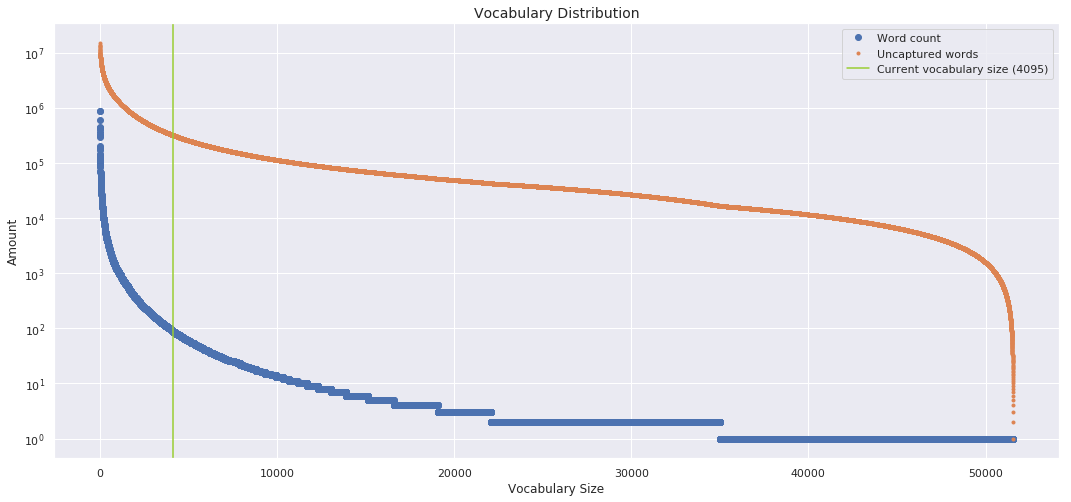

In [120]:
plt.title('Vocabulary Distribution')

wc_vals = list(word_count.values())

plt.plot(wc_vals, 'o', label='Word count')
plt.plot(sum(wc_vals)-np.cumsum(wc_vals), '.', label='Uncaptured words')
plt.axvline(x=VOCABULARY_SIZE, color='yellowgreen', label=f'Current vocabulary size ({VOCABULARY_SIZE})')

plt.gca().set_yscale('log')
# plt.gca().set_xscale('log')

plt.xlabel('Vocabulary Size')
plt.ylabel('Amount')
plt.legend()

plt.show()

In [122]:
# word sequences to indexed sequences

vocab = list(word_count)[:VOCABULARY_SIZE]
word2index = {word:index for index, word in enumerate(vocab, start=1)}

word_seq2indexed = lambda reviews: [
    [
        word2index.get(word, 0)
        for word in review
    ]
    for review in reviews
]

reviews_seq = word_seq2indexed(reviews_word_seq)
reviews_test_seq = word_seq2indexed(reviews_test_word_seq)

# no need for these anymore
del reviews_word_seq, reviews_test_word_seq

In [40]:
# set max sequence length so that it captures 99% full reviews
review_lengths = np.array(list(map(len, reviews_seq)))
sequence_cutoff_legth = int(np.quantile(review_lengths, 0.99))

In [41]:
plt.title('Distribution of Review Lengths')

sns.distplot(
    review_lengths,
    hist_kws=dict(label='Normalized histogram'),
    kde=True,
    kde_kws=dict(label='Kernel density'),
    rug=True,
    norm_hist=False,
    rug_kws=dict(color='orangered', label='Review'),
    axlabel='Sequence Length',
)
plt.axvline(
    x=sequence_cutoff_legth,
    color='yellowgreen',
    label=f'Sequence cutoff length ({sequence_cutoff_legth})'
)

plt.gca().set_xscale('log')

plt.xlabel('Review Length')
plt.ylabel('Density')
plt.legend()

plt.show()

KeyboardInterrupt: 

In [ ]:
# pad the sequences

reviews_seq = keras.preprocessing.sequence.pad_sequences(
    reviews_seq,
    maxlen=sequence_cutoff_legth
)

reviews_test_seq = keras.preprocessing.sequence.pad_sequences(
    reviews_test_seq,
    maxlen=sequence_cutoff_legth
)

## Model

If you prefer to see a graphical representation rather than the code, scroll below.

The model is based on a merge of two models which I found to perform relatively well
on the regression task, both had about 1.0 - 1.2 mean absolute validation error
(when measured against original 1 - 10 integer labels).
At first, I only made an ensemble of the two
(the recurrent branch having its own embeddings and the recurrent part having spaCy's pretrained embeddings).
Many iterative changes to the architecture were inconclusive - such as having both embeddings trainable,
having only single common embedding (for simplicity and speed, I decided to go with this option),
larger model on top of the branches...
However, I managed to improve slightly on the previous results
and the model was consistently better than my original [benchmark (S. Prikhodko et al.)](https://www.kaggle.com/stasian/predicting-review-scores-using-neural-networks).
I also added the "useful count" attribute as an auxiliary input which delivered another slight boost, depending on the architecture.

I was interested in repurposing the model for the classification problem introduced in the [original paper](https://dl.acm.org/citation.cfm?id=3194677).
The model was strongly overfitting and it proved to be very challenging to regularize.
Adding the regressive output layer helped to alleviate the overfitting,
albeit the the regressive branch started underfitting...
That trade inspired me to modify the classifier for the original 10 classes,
in belief that the two outputs will support and regularize each other when they share a common distribution of targets.
The results are positive (although the classifier still overfits but still achieves great performance).

### Building the model

In [ ]:
# extract embeddings for our vocabulary

embedding_weights = np.zeros((
    VOCABULARY_SIZE+1, # indices/hashes
    nlp.vocab.vectors_length # embedding dimmension
))

for word, index in word2index.items():
    embedding_weights[index] = nlp.vocab[word].vector

In [ ]:
# here it goes :-)

input_reviews = layers.Input(shape=(sequence_cutoff_legth,), dtype='int32')


embedding = layers.Embedding(
    *embedding_weights.shape,
    weights=[embedding_weights],
    input_length=sequence_cutoff_legth,
    trainable=True,
)(input_reviews)
embedding = layers.GaussianNoise(0.15)(embedding)


branch_a = layers.CuDNNLSTM(128)(embedding)
branch_a = layers.BatchNormalization()(branch_a)
branch_a = layers.Dropout(0.3)(branch_a)
branch_a = layers.GaussianNoise(0.4)(branch_a)

branch_a = layers.Dense(10, activation='relu')(branch_a)
branch_a = layers.BatchNormalization()(branch_a)
branch_a = layers.GaussianNoise(0.4)(branch_a)


branch_b = layers.Conv1D(16, 3, padding='same', activation='relu')(embedding)
branch_b = layers.BatchNormalization()(branch_b)
branch_b = layers.MaxPool1D(2)(branch_b)

branch_b = layers.Conv1D(32, 3, padding='same', activation='relu')(branch_b)
branch_b = layers.BatchNormalization()(branch_b)
branch_b = layers.MaxPool1D(2)(branch_b)

branch_b = layers.Conv1D(64, 3, padding='same', activation='relu')(branch_b)
branch_b = layers.BatchNormalization()(branch_b)
branch_b = layers.MaxPool1D(2)(branch_b)

branch_b = layers.Conv1D(128, 3, padding='same', activation='relu')(branch_b)
branch_b = layers.Dropout(0.3)(branch_b)

branch_b = layers.GlobalAvgPool1D()(branch_b)
branch_b = layers.BatchNormalization()(branch_b)
branch_b = layers.Dropout(0.3)(branch_b)
branch_b = layers.GaussianNoise(0.4)(branch_b)

branch_b = layers.Dense(10, activation='relu')(branch_b)
branch_b = layers.BatchNormalization()(branch_b)
branch_b = layers.GaussianNoise(0.4)(branch_b)


input_useful_count = layers.Input(shape=(1,))


intermediate = layers.concatenate([branch_a, branch_b, input_useful_count])
intermediate = layers.Dropout(0.3)(intermediate)

intermediate = layers.Dense(32, activation='relu')(intermediate)
intermediate = layers.BatchNormalization()(intermediate)
intermediate = layers.Dropout(0.3)(intermediate)
intermediate = layers.GaussianNoise(0.4)(intermediate)


regression_top = layers.Dense(10, activation='relu')(intermediate)
regression_top = layers.BatchNormalization()(regression_top)
regression_top = layers.GaussianNoise(0.1)(regression_top)

regression_top = layers.Dense(1, activation='sigmoid', name='regressor')(regression_top)


classification_top = layers.Dense(10, activation='relu', activity_regularizer=l2(2e-4))(intermediate)
classification_top = layers.BatchNormalization()(classification_top)
classification_top = layers.Dropout(0.2)(classification_top)
classification_top = layers.GaussianNoise(0.2)(classification_top)

classification_top = layers.Dense(10, activation='softmax', name='classifier')(classification_top)


model = keras.models.Model(
    inputs=[input_reviews, input_useful_count],
    outputs=[regression_top, classification_top],
)
model.summary()

In [ ]:
# visualize the model graph

model_viz = keras.utils.vis_utils.model_to_dot(model)
IPython.display.SVG(model_viz.create(prog='dot', format='svg'))

In [ ]:
# standard scaling of the "useful count" attribute

useful_count_mean = reviews_df.usefulCount.mean()
useful_count_std = reviews_df.usefulCount.std()

reviews_df.usefulCount += useful_count_mean
reviews_df.usefulCount /= useful_count_std

reviews_test_df.usefulCount += useful_count_mean
reviews_test_df.usefulCount /= useful_count_std

In [ ]:
# training/validation split and creation

rating = reviews_df.rating.values

(
    y_regr_train, y_regr_valid,
    y_clas_train, y_clas_valid,
    x1_train, x1_valid,
    x2_train, x2_valid,
) = train_test_split(
    # reggression output between 0.1 and 1.0
    rating / 10,
    # classification between 0 and 9 and to categorical
    keras.utils.to_categorical(rating-1, num_classes=10),
    
    reviews_seq, # main input
    reviews_df.usefulCount.values, # aux. input
    
    # options
    test_size=VALIDATION_SPLIT,
    stratify=reviews_df.rating.values
)

x_train = [x1_train, x2_train]
y_train = [y_regr_train, y_clas_train]

x_valid = [x1_valid, x2_valid]
y_valid = [y_regr_valid, y_clas_valid]

### Training

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=['mae', 'categorical_crossentropy'],
    metrics={'classifier':'accuracy', 'regressor':'mae'},
    # put more weight to the regressor
    loss_weights=[2,1],
)

In [ ]:
# let's give it some work out!

history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_valid, y_valid),
    batch_size=256,
    epochs=300,
    verbose=0,
    callbacks=[
        keras.callbacks.ModelCheckpoint(
            'model'
            '-epoch_{epoch:02d}'
            '-regr_mae_{val_regressor_loss:.2f}'
            '-clas_acc_{val_classifier_acc:.2f}.hdf5',
            monitor='val_regressor_loss',
            verbose=0,
            save_best_only=True,
            save_weights_only=False,
            mode='auto',
            period=1,
        ),
    ],
)


model.save('model-last_epoch.hdf5')

In [ ]:
def plot_history(history, skip_first_n_epochs=0):
    """Show information about the training"""
    
    # plot every train-valid metric pair separately
    for metric in history:
        if not metric.startswith('val_'):
            x = np.arange(len(history[metric]))+1

            y_train = history[metric][skip_first_n_epochs:]
            y_valid = history['val_'+metric][skip_first_n_epochs:]

            plt.plot(x, y_train)
            plt.plot(x, y_valid)

            plt.legend([metric, 'val_'+metric], fontsize='large')

            plt.title(
                f'{metric.upper()} - '
                f'min/max [train: {min(y_train):.3f}/{max(y_train):.3f}, '
                f'valid: {min(y_valid):.3f}/{max(y_valid):.3f}]'
            )
            
            plt.xlabel('epoch')
            plt.show()
            
plot_history(history.history)

## Results

*Convention: `y_...` denotes the true score, `yx_...` is the predicted*

In [ ]:
# evaluate the model

def y2original(y):
    """Convert Y result to the original score scale"""
    y_regr, y_clas = y
    y_regr = 10*y_regr
    y_clas = np.argmax(y_clas, axis=1) + 1
    return y_regr, y_clas

x_test = [reviews_test_seq, reviews_test_df.usefulCount.values]

y_test = reviews_test_df.rating.values
y_train = y2original(y_train)[0]
y_valid = y2original(y_valid)[0]

# evaluate model and convert output
yx_train_regr, yx_train_clas = y2original(model.predict(x_train))
yx_valid_regr, yx_valid_clas = y2original(model.predict(x_valid))
yx_test_regr,  yx_test_clas  = y2original(model.predict(x_test))

In [ ]:
from sklearn.metrics import cohen_kappa_score, mean_absolute_error, accuracy_score

def show_metrics(title, y_true, y_regr, y_clas):
    y_regr_closest = np.round(y_regr)
    
    fmt = '{:<16} | {:>8} | {:>8} | {:>8}'.format
    nums2str = lambda *nums: (f'{n:.3f}' for n in nums)
    
    print(fmt(title, 'MAE', 'KAPPA', 'ACCURACY'))
    print(fmt(' regression', *nums2str( 
            mean_absolute_error(y_true, y_regr),
            cohen_kappa_score(y_true, y_regr_closest),
            accuracy_score(y_true, y_regr_closest)
    )))
    
    print(fmt(' classification', *nums2str( 
            mean_absolute_error(y_true, y_clas),
            cohen_kappa_score(y_true, y_clas),
            accuracy_score(y_true, y_clas)
    )))
    print()
    

**MAE**<br/>
Mean Absolute Error shows how much off the predictions are from the true rating on average (measured against the original 1 to 10 rating).

**KAPPA**<br/>
[Cohen's Kappa](https://www.statisticshowto.datasciencecentral.com/cohens-kappa-statistic/)
measures how much better the classifier is compared to guessing (it considers the rating distribution).

**ACCURACY**<br/>
Accuracy gives the plain fraction of the correct predictions.

In [ ]:
show_metrics('TRAINING SET', y_train, yx_train_regr, yx_train_clas)
show_metrics('VALIDATION SET', y_valid, yx_valid_regr, yx_valid_clas)
show_metrics('TEST SET', y_test, yx_test_regr, yx_test_clas)

### Visualizing predictions

*(slightly lengthy, sorry...)*

In [ ]:
# rearange so that true labels lump together
# (sort is stable so within a rating level train-valid-test order holds)

Y = np.concatenate([y_train, y_valid, y_test])
YX_REGR = np.concatenate([yx_train_regr, yx_valid_regr, yx_test_regr])
YX_CLAS = np.concatenate([yx_train_clas, yx_valid_clas, yx_test_clas])
_INDEX = np.arange(len(Y))

quadratuplets = zip(Y, YX_REGR, YX_CLAS, _INDEX)
rearanged = sorted(quadratuplets, key=lambda q: q[0])

y, yx_regr, yx_clas, index = zip(*rearanged)

In [ ]:
# separate them again, so that we can add colors

# alternative would be to make an array with colors already earlier
# and add it to the sorting above, then having it as an argument
# for scatter plot, it was, however, slow and not so pretty :-)

# for axis indices on the plot
axis = np.arange(len(y))

index_train = []
index_valid = []
index_test = []
t1, t2 = len(y_train), len(y_train) + len(y_valid)
for i, a in zip(index, axis):
    if i < t1:
        index_train.append(a)
    elif i < t2:
        index_valid.append(a)
    else:
        index_test.append(a)

axis_train = axis[index_train]
axis_valid = axis[index_valid]
axis_test = axis[index_test]

yx_train_regr = np.asarray(yx_regr)[index_train]
yx_valid_regr = np.asarray(yx_regr)[index_valid]
yx_test_regr  = np.asarray(yx_regr)[index_test]

yx_train_clas = np.asarray(yx_clas)[index_train]
yx_valid_clas = np.asarray(yx_clas)[index_valid]
yx_test_clas  = np.asarray(yx_clas)[index_test]

In [ ]:
# the plot finally
cm = plt.cm.viridis

plt.plot(axis_train, yx_train_regr, '.', alpha=0.1, color=cm(0.75))
plt.plot(axis_valid, yx_valid_regr, '.', alpha=0.1, color=cm(0.8))
plt.plot(axis_test,  yx_test_regr , '.', alpha=0.1, color=cm(0.9))

plt.plot(axis_train, yx_train_clas, 'o', alpha=0.1, color=cm(0.1))
plt.plot(axis_valid, yx_valid_clas, 'o', alpha=0.1, color=cm(0.17))
plt.plot(axis_test,  yx_test_clas , 'o', alpha=0.1, color=cm(0.3))

plt.plot(axis, y, 'o', c='#88888801', markersize=12)

legend_label = lambda c, l: plt.Line2D(
    [0], [0], linewidth=0, marker='o', color=c, label=l)

legend_elements = [
    legend_label('#888888', 'Actual score'),
    legend_label(cm(0.1), 'Classification (training)'),
    legend_label(cm(0.17), 'Classification (validation)'),
    legend_label(cm(0.3), 'Classification (test)'),
    legend_label(cm(0.75), 'Regression (training)'),
    legend_label(cm(0.8), 'Regression (validation)'),
    legend_label(cm(0.9), 'Regression (test)'),
]

plt.legend(handles=legend_elements)
plt.xticks([])
plt.xlabel('Reviews')
plt.ylabel('Rating')
plt.show()

## Conclusion

This is a really nice dataset to play with, not only for text regression.

It seems that the vocabulary size (tried between 1000 and 8000)
and text preprocessing (punctuation/numbers, stop words, lemmas, indexing/hashing)
for this model are near the sweet spot.

The model still overfits.
Regularization of weights turned out to be hard - as it either had barely any effect
or it rendered the model unable to learn.
Other hyperparameters can, of course, be still improved, however,
I doubt it would deliver much improvement over smarter architecture and preprocessing.

Techniques such as bidirectional or multilayer RNN and attention were not fruitful, although,
I have not put a lot of effort into optimizing them...

Nevertheless, considering the general dificulty of understanding language
and amount of noise in the data (like sarkasm, subjective preferences),
I think the results are great.